In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lightkurve import search_targetpixelfile
from lightkurve import KeplerTargetPixelFile

from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from photutils.psf import BasicPSFPhotometry

from astropy.modeling.fitting import LevMarLSQFitter, LinearLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm
from astropy.table import Table

from photutilspsf.photutilspsf import read_fits_table, select_members_on_tpf

In [2]:
from copy import deepcopy

In [19]:
def define_photometry(sigma_psf=0.5, group_psf=1.5, fitshape=(11,11)):
    daogroup = DAOGroup(group_psf *
                        sigma_psf * 
                        gaussian_sigma_to_fwhm)

    bkg = MMMBackground()
    fitter = LevMarLSQFitter()
    psf_model = IntegratedGaussianPRF(sigma=sigma_psf)

    psf_model.x_0.fixed = True
    psf_model.y_0.fixed = True
    
    return BasicPSFPhotometry(group_maker=daogroup,
                              bkg_estimator=bkg,
                              psf_model=psf_model,
                              fitter=LevMarLSQFitter(),
                              fitshape=fitshape)

def get_members_photometry_table(photometry, memberspath, TPF, index):
    image = TPF.flux[index,:,:]
    members = read_fits_table(memberspath)
    rselect = select_members_on_tpf(TPF, members)
    pos = Table(names=['x_0', 'y_0'], data=[rselect['xcentroid'],
                                            rselect['ycentroid']])
    result_table =  photometry(image=image, init_guesses=pos)
    del image
    return result_table
    
def get_members_photometry_residual_image(photometry):
    return photometry.get_residual_image()

In [3]:
EPIC = 200062544
C = 7
index = 256
memberspath = 'data/olivares_members_r147.fit'

TPF = search_targetpixelfile(EPIC).download()

In [20]:
photometry = define_photometry(sigma_psf=1.5, group_psf=2.5,)

result_tab = get_members_photometry_table(photometry, memberspath, TPF,index)

residual_image = get_members_photometry_residual_image(photometry)

(0, 49)

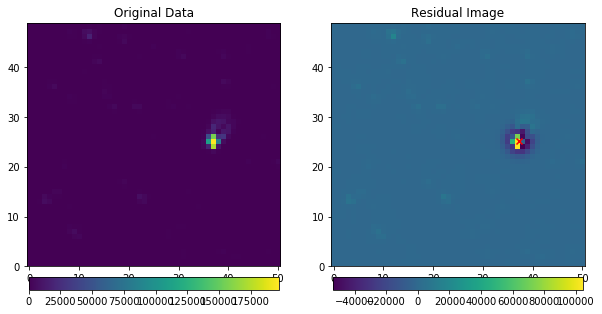

In [21]:
image = TPF.flux[index,:,:]

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1,)

plt.imshow(image, cmap='viridis', aspect=1, interpolation='nearest',)
plt.ylim(0,49)
plt.title('Original Data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.subplot(1 ,2, 2)
plt.scatter(result_tab['x_fit'],result_tab['y_fit'],c='r', marker='x')
plt.imshow(residual_image, cmap='viridis', aspect=1,
           interpolation='nearest', origin='lower')
plt.title('Residual Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.ylim(0,49)
